# Deep Learning Question & Answer Chatbot

I will be implementing a chat bot that can answer questions given a set of sentences. The chatbot will use a subset of the Babi Data Set from Facebook Research; it already contains stories(sentences), queries(questions), and answers. 
Here is a link to the Babi Data Sets as well as the paper describing the bAbI tasks in detail:

Full Details: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698

Here is a link to paper this implementation is based on:
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  https://arxiv.org/pdf/1503.08895.pdf
  
The bot currently returns a yes or a no to each question asked. However, I plan on integrating a Natural Language Generation component to introduce some meaningful dialogue as well as a speech to text component.

## Imports

In [1]:
import pickle
import numpy as np

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [3]:
# For creating the model
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [88]:
import matplotlib.pyplot as plt

/home/alberto/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [101]:
from pprint import pprint

## Load the Data

In [48]:
with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp) # List

In [49]:
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp) # List

10:1 ratio for training data vs testing data; there are 10,000 points for train_data and 1,000 points for test_data. 

In [50]:
train_data[10]

(['Sandra',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.',
  'Sandra',
  'moved',
  'to',
  'the',
  'office',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'office', '?'],
 'yes')

In [51]:
story_sentence = ' '.join(train_data[10][0]) #Story/Sentence
query_question = ' '.join(train_data[10][1]) #Query/Question
answer = train_data[10][2] #Answer to question

In [52]:
print("Sentence: ", story_sentence)
print("Question: ", query_question)
print("Answer:   ", answer)

Sentence:  Sandra went back to the hallway . Sandra moved to the office .
Question:  Is Sandra in the office ?
Answer:    yes


## Create a Vocabulary of all of the Words

In [53]:
# Set that contains the vocab words
vocab = set()

In [54]:
all_data = train_data + test_data 

for story, question , answer in all_data:
    # Creates a vocabulary of all the distinct words inside our dataset 
    vocab = vocab | set(story) # vocab ∪ Story. Continuously adds unique words
    vocab = vocab | set(question) # vocab ∪ question. Continuously adds unique words

In [55]:
# Add in the two possible answers 
vocab.add('no')
vocab.add('yes')

In [56]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [57]:
# Reserve 0 for Keras pad_sequences 
vocab_size = len(vocab) + 1 # + 1 to add an extra space for a 0 for Keras's pad_sequences

In [58]:
# Find longest story
longestStory = max(( (len(data[0])) for data in all_data )) 
longestQuery = max(( (len(data[1])) for data in all_data )) 

In [59]:
print(longestStory)
print(longestQuery)

156
6


## Vectorize Data

In [60]:
# Creates integer encoding for the sequences of words
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab) # This method creates the vocabulary index based on word frequency

In [61]:
tokenizer.word_index

{'?': 1,
 'sandra': 2,
 'the': 3,
 'back': 4,
 'picked': 5,
 'grabbed': 6,
 'hallway': 7,
 'office': 8,
 'garden': 9,
 'in': 10,
 'apple': 11,
 'bathroom': 12,
 'put': 13,
 'down': 14,
 'went': 15,
 'john': 16,
 'got': 17,
 'there': 18,
 'discarded': 19,
 'bedroom': 20,
 'to': 21,
 'moved': 22,
 'travelled': 23,
 'mary': 24,
 'milk': 25,
 'dropped': 26,
 'no': 27,
 'took': 28,
 'left': 29,
 'up': 30,
 'football': 31,
 'yes': 32,
 'kitchen': 33,
 'journeyed': 34,
 '.': 35,
 'is': 36,
 'daniel': 37}

In [62]:
trainStoryText = []
trainQueryText = []
trainAnswers = []

for story, query, answer in train_data:
    trainStoryText.append(story)
    trainQueryText.append(query)
    trainAnswers.append(answer)

In [63]:
 # Transforms each word in the sentences to a sequence of integers.
trainStorySeq = tokenizer.texts_to_sequences(trainStoryText)

In [64]:
def vectorizeStories(data, word_index = tokenizer.word_index, maxStoryLen = longestStory, maxQueryLen = longestQuery):
    """
    Vectorizes stories, queries, & answers into padded sequences. 
   
    Parameters: 
        data: All the data (Stories, Queries, Answers)
        word_index: A word index dictionary. Defaulted to our tokenizer.word_index
                    Can be overrided to other datasets or other sets of questions
        maxStoryLen: Length of the longest story (Will be used for the pad_sequences function)
        maxQueryLen: Length of the longest query (Will be used for the pad_sequences function)
        
        We need the max story & query length because we are using padded sequences; not every story/query 
        is the same length and our RNN that we're using for training needs everything to be the same length 
        We'll pad the inputs with 0s in case there's a story or query that is too short. Or we can cut down 
        a story or query if it is too long.
        
    Returns: 
        this (tuple): A tuple of the form (X, Q, A) (padded based on max lengths)    
    """
    X = [] # X := Stories
    Q = [] # Q := Queries
    A = [] # A := Answers (yes/no)
    
    for story, query, answer in data:
        # Convert the raw words into integers through a word index value
        
        # Grabs the word index for every word in story
        # [9, 34, ...]
        x = [word_index[word.lower()] for word in story]
        # Grabs the word index for every word in query
        q = [word_index[word.lower()] for word in query]
        
        # Index 0 is reserved since we are using pad sequences, so we add + 1
        a = np.zeros(len(word_index) + 1)
        
        # a is an empty matrix of NP zeros so we'll use numpy logic to create this assignment (Yes/No)
        a[word_index[answer]] = 1
        
        # We now append each set to their appropriate output list.
        X.append(x)
        Q.append(q)
        A.append(a)
    
    # Now that we have converted the words to numbers, we pad the sequences so they are all of equal length.
    X_padded_seqs = pad_sequences(X, maxlen = maxStoryLen)
    Q_padded_seqs = pad_sequences(Q, maxlen= maxQueryLen)
    answers = np.array(A)
    
    # Now that the sequences are padded based on their max length, the RNN can be trained on uniformly long sequences.
    # Returns tuple for unpacking. 
    return (X_padded_seqs, Q_padded_seqs, answers)

In [65]:
inputsTrain, queriesTrain, answersTrain = vectorizeStories(train_data)
inputsTest, queriesTest, answersTest = vectorizeStories(test_data)

In [66]:
print(inputsTrain)

[[ 0  0  0 ...  3 20 35]
 [ 0  0  0 ...  3  7 35]
 [ 0  0  0 ...  3 12 35]
 ...
 [ 0  0  0 ...  3 20 35]
 [ 0  0  0 ... 25 18 35]
 [ 0  0  0 ... 11 18 35]]


In [67]:
print(inputsTest)

[[ 0  0  0 ...  3 20 35]
 [ 0  0  0 ...  3  9 35]
 [ 0  0  0 ...  3  9 35]
 ...
 [ 0  0  0 ...  3 11 35]
 [ 0  0  0 ...  3  9 35]
 [ 0  0  0 ... 11 18 35]]


In [68]:
print(answersTest)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [69]:
tokenizer.word_index['yes']

32

In [70]:
tokenizer.word_index['no']

27

In [71]:
sum(answersTest)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0., 497.,
         0.,   0.,   0.,   0.,   0.])

We can see that we have 497 'yes's at index location 7 and 29 'no's at index location 29.

Our stories, queries, and answers are now successfully vectorized

## Create the model

In [72]:
# We have 2 inputs: The stories and questions
# We'll need to use place holders so we will use `Input()` to insantiate a Keras tensor.

In [73]:
# Shape = (Longest Story, Batch Size)
inputSequence = Input((longestStory, ))
query = Input((longestQuery, ))

## Build the Neural Network 

There are three encoders we will build
* Input Encoder C
* Input Encoder M
* Question Encoder

We are following this model from the paper:
![PaperModel](.\PaperModel.png)
<i><center>Figure 1: (a): A single layer version of the model. (b): A three layer version of the model.</center></i>

### Input Encoder C

In [74]:
# This input gets embedding to a sequence of vectors
inputEncoderC = Sequential()
# Add 2 layers to it
inputEncoderC.add(Embedding(input_dim = vocab_size, output_dim = longestQuery))
# Turns off a random % of nuerons. Helps with overfitting. Can increase droupout and train longer if wanted
inputEncoderC.add(Dropout(0.3))

# This encoder will output:
# output: (samples, stories max len, longestQuery)

### Input Encoder M

In [75]:
# This input gets embedding to a sequence of vectors
inputEncoderM = Sequential()
# Add 2 layers to it
# The dimension is set to 64 as the researchers found it to give good results for that vocab size. 
inputEncoderM.add(Embedding(input_dim = vocab_size, output_dim = 64)) 
# Turns off a random % of nuerons. Helps with overfitting. Can increase droupout and train longer if wanted
inputEncoderM.add(Dropout(0.3))

# This encoder will output:
# output: (samples, stories max len, embedding dim)

### Question Encoder

In [76]:
# This input gets embedding to a sequence of vectors. The paper states: The query q is also embedded (again, in the simplest case via another embedding matrix
# B with the same dimensions as A) to obtain an internal state u. So the output dimension will match our encoder m.
questionEncoder = Sequential()
# Add 2 layers to it
questionEncoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = longestQuery))
# Turns off a random % of nuerons. Helps with overfitting. Can increase droupout and train longer if wanted
questionEncoder.add(Dropout(0.3))

# This encoder will output:
# output: (samples, longestQuery, embedding dim)

### Encode the Sequences 

In [77]:
# Enocoded <-- Encoder(input)
# encode the input sequence and questions (which are indices) to sequences of dense vectors
# We already have our placeholders for the inputs (inputSequence & query)
inputEncodedM = inputEncoderM(inputSequence)
inputEncodedC = inputEncoderC(inputSequence)
questionEncoded = questionEncoder(query)

In [78]:
# As stated in the paper: 
# In the embedding space, we compute the match between u (1st input vector seq.) and each memory m_i (the query) by taking the innner product
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([inputEncodedM, questionEncoded], axes = (2,2))

Now we call an activation function on this match (Softmax).

$$p_{i}=\operatorname{Softmax}\left(u^{T} m_{i}\right)$$
Where
$$\operatorname{Softmax}\left(z_{i}\right)=e^{z_{i}} / \sum_{j} e^{z_{j}}$$

In [79]:
match = Activation('softmax')(match)

Now we add this match matrix with the second input vector sequence

In [80]:
response_vector = add([match, inputEncodedC]) # (samples, longestStory, longestQuery)
response_vector = Permute((2, 1))(response_vector)  # (samples, longestQuery, longestStory)

In [81]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response_vector, questionEncoded])
answer # (batch size, 6 x 220)

<tf.Tensor 'concatenate_4/concat:0' shape=(?, 6, 220) dtype=float32>

Now that we have our answer, we are going to reduce it with a RNN, specifically a LSTM layer

In [82]:
# Reduce with LSTM
answer = LSTM(32)(answer)  # (samples, 32)

In [83]:
# Perform one more series of Regularization with Dropout
answer = Dropout(0.5)(answer)
# Dense output layer for the vocab size (samples, vocab_size) # YES/NO 0000
answer = Dense(vocab_size)(answer) 

Output a probability distribution over the vocabulary bc we'll essentially see a bunch of zeros except some probability on YES and some probability on NO. we'll pass this into a Softmax in order to turn it into a 0 or 1

In [84]:
# Output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# Building the final model
# This answer links together all the encoders (encoder C, encoder M, Question encoder).
# This is how we link our model to those encodings.
model = Model([inputSequence, query], answer) 

# We expect to see only high probabilities on YES or NO, but we're not working with a Binary Cross-Entropy Loss 
# since we we have a larger vocab size than that. Altough we should only expect to see only high probabilities on YES or NO
# categorical_crossentropy since we are doing this across the entire vocabulary. 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
__________________________________________________________________________________________________
dot_3 (Dot

In [133]:
'''
Train the model for 3 epochs, in batches of 16 samples,
on data stored in the Numpy array X_train,
and labels stored in the Numpy array y_train:

model.fit(X_train, y_train, nb_epoch=3, batch_size=16, verbose=1)

What you will see with mode verbose=1:
Train on 37800 samples, validate on 4200 samples
Epoch 0
37800/37800 [==============================] - 7s - loss: 0.0385
Epoch 1
37800/37800 [==============================] - 8s - loss: 0.0140
Epoch 2
10960/37800 [=======>......................] - ETA: 4s - loss: 0.0109

Smaller batch sizes with longer training epochs should lead to slightly better results. 
'''
# Training on input stories and input questions
x_train = [inputsTrain, queriesTrain]
correctLabels = answersTrain

validSet = ([inputsTest, queriesTest], answersTest)

chatbotHistory = model.fit(x_train, correctLabels, batch_size=32, epochs=120, validation_data=validSet)

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 5s 463us/step - loss: 0.5937 - acc: 0.6945 - val_loss: 0.5673 - val_acc: 0.7170
Epoch 2/120
10000/10000 [==============================] - 4s 395us/step - loss: 0.5539 - acc: 0.7317 - val_loss: 0.5375 - val_acc: 0.7530
Epoch 3/120
10000/10000 [==============================] - 6s 562us/step - loss: 0.5232 - acc: 0.7538 - val_loss: 0.4943 - val_acc: 0.7780
Epoch 4/120
10000/10000 [==============================] - 4s 404us/step - loss: 0.5005 - acc: 0.7708 - val_loss: 0.4650 - val_acc: 0.7870
Epoch 5/120
10000/10000 [==============================] - 4s 377us/step - loss: 0.4803 - acc: 0.7824 - val_loss: 0.4459 - val_acc: 0.7930
Epoch 6/120
10000/10000 [==============================] - 4s 382us/step - loss: 0.4635 - acc: 0.7864 - val_loss: 0.4385 - val_acc: 0.7940
Epoch 7/120
10000/10000 [==============================] - 4s 385us/step - loss: 0.4462 - acc: 0.8018 - val_loss: 0.4

10000/10000 [==============================] - 4s 403us/step - loss: 0.1823 - acc: 0.9242 - val_loss: 0.6967 - val_acc: 0.8050
Epoch 118/120
10000/10000 [==============================] - 4s 411us/step - loss: 0.1795 - acc: 0.9254 - val_loss: 0.6690 - val_acc: 0.8070
Epoch 119/120
10000/10000 [==============================] - 4s 389us/step - loss: 0.1739 - acc: 0.9296 - val_loss: 0.7425 - val_acc: 0.8100
Epoch 120/120
10000/10000 [==============================] - 4s 406us/step - loss: 0.1808 - acc: 0.9268 - val_loss: 0.6730 - val_acc: 0.8210


## Evaluating the Model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


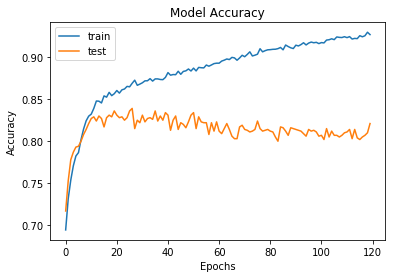

In [134]:
#pprint(chatbotHistory.history)
print(chatbotHistory.history.keys())
# Summarize the history for accuracy
#Loss & and Accuracy are essentially inverses of each other. We are trying to increase accuracy/reduce loss
plt.plot(chatbotHistory.history['acc']) 
plt.plot(chatbotHistory.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the Model

In [135]:
model.save("models/chatbot_120_epochs.h5")

In [106]:
# To load a different model
# model.load_weights("models/chatbot_10_epochs.h5")

In [136]:
# Evaluate on test set
# Trying to predict based on the test set so the answer labels are not passed in
predictedResults = model.predict((validSet[0]))

In [138]:
story =' '.join(word for word in test_data[0][0])
print(f'Story: {story}')

query = ' '.join(word for word in test_data[0][1])
print(f'Question: {query}')

print("Correct Answer: ",test_data[0][2])

Story: Mary got the milk there . John moved to the bedroom .
Question: Is John in the kitchen ?
Correct Answer:  no


In [139]:
predictedResults.shape #37 vocab words + 1 for padding

(1000, 38)

In [140]:
predictedResults[0]

array([1.9816977e-15, 2.0368580e-15, 2.3015473e-15, 1.9834979e-15,
       2.3366147e-15, 2.1451880e-15, 1.8299696e-15, 2.1858632e-15,
       2.4458945e-15, 1.8294811e-15, 2.1176095e-15, 2.0684839e-15,
       1.9871332e-15, 2.2822343e-15, 2.0055853e-15, 2.1186357e-15,
       2.2708581e-15, 2.2851354e-15, 1.8959331e-15, 2.1542661e-15,
       2.0863381e-15, 2.0676320e-15, 2.4000691e-15, 2.3236106e-15,
       2.2063965e-15, 2.0691865e-15, 1.8461805e-15, 9.9997878e-01,
       2.2069016e-15, 2.1036722e-15, 2.2178560e-15, 1.9348174e-15,
       2.1226384e-05, 2.5996413e-15, 2.1325740e-15, 1.9930545e-15,
       2.1961269e-15, 2.1997153e-15], dtype=float32)

In [141]:
mostyProbableWord = np.argmax(predictedResults[0]) #Word with the highest probability

In [142]:
print(mostyProbableWord)

27


In [143]:
#Generate the prediction from model
for key, val in tokenizer.word_index.items():
    #Searching for the word
    if val == mostyProbableWord:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", predictedResults[0][mostyProbableWord])

Predicted answer is:  no
Probability of certainty was:  0.9999788


Very confident at 120 epochs. Although it appears that it wasn't necessary to train for 120 epochs. Probably could've trained for less. Will do an analysis later.

In [130]:
# To expand training and test set, I need to create new stories, new questions, and correct answers.
# Currently limited to using only the words found in the vocabulary the network was trained on. 
# Probably could make a simple one to showcase it's potential for talking about business related conversations

In [132]:
# Will check prediction on my own story and my own ques (limited to using the vocab words of course) 